In [1]:
from typing import Tuple

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torchvision.transforms as transforms

#Returns tensor of shape (num_patches, channels, height, width)
#The patches are ordered lexicographically, e.g.
# 0 1 2
# 3 4 5
def get_image_patches(image : Tensor, 
                      patch_size : Tuple[int,int]) -> Tensor:
    # batch, channels, height, width
    b, c, h, w = image.shape
    patch_h, patch_w = patch_size
    
    # Apply circular padding
    pad_h = (patch_h - (h % patch_h)) % patch_h
    pad_w = (patch_w - (w % patch_w)) % patch_w
    print(f"pad_h: {pad_h}")
    print(f"pad_w: {pad_w}")

    padded_image = None
    if pad_h > 0 or pad_w > 0:
        padded_image = F.pad(image, (0, pad_w, 0, pad_h), mode='circular')
    else:
        padded_image = image

    # Unfold to extract patches
    print(f"Padded image shape: {padded_image.shape}")
    patches = padded_image.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)

    print(f"Patches shape (before reshape): {patches.shape}")
    
    # Reshape tensor
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(-1, c, patch_h, patch_w)

    print(f"Patches shape: {patches.shape}")
    
    return patches


In [2]:
from typing import Tuple

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torchvision.transforms as transforms

def stitch_image_patches(patches: Tensor, 
                         original_shape: Tuple[int, int, int, int], 
                         patch_size: int) -> Tensor:
    """
    Reconstruct the original image from patches.

    Parameters:
    patches (Tensor): Tensor of shape (num_patches, channels, patch_size, patch_size)
    original_shape (Tuple[int, int, int, int]): Original image shape (batch, channels, height, width)
    patch_size (int): Size of each patch (assuming square patches)

    Returns:
    Tensor: Reconstructed image of shape (batch, channels, height, width)
    """

    b, c, h, w = original_shape
    patches_per_col = (h + patch_size-1) // patch_size
    patches_per_row = (w + patch_size-1) // patch_size

    padded_h = patch_size * patches_per_col
    padded_w = patch_size * patches_per_row
    
    # Reshape patches to the original dimensions
    patches = patches.view(b, patches_per_col, patches_per_row, c, patch_size, patch_size)
    
    # Permute to match the original image dimensions
    patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
    
    # Combine patches
    image = patches.view(b, c, padded_h, padded_w)
    
    return image

In [3]:
from pathlib import Path

import torch
import torch.nn as nn

from unet_SANDBOX import load_model

from typing import Tuple

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torchvision.transforms as transforms

# General device handling: Check for CUDA/GPU, else fallback to CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model_file_path = Path("/Users/karan/Microtubules/Models/model-1.pth")

model : nn.Module
config : dict
model, config = load_model(model_file_path=model_file_path,
                            device=device)
patch_size = config['patch_size']
print("Loaded trained U-Net model.\n")


# Load image
image_file_path = Path("/Users/karan/MTData/SimulatedData/Images/image-429.png")
image = np.array(Image.open(image_file_path).convert('L'))

# Convert image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])
transformed_image  = transform(image)
if not isinstance(transformed_image, Tensor):
    raise ValueError('The transform of the image is not a Tensor')
image_tensor : Tensor = transformed_image.clone().detach()

# Add batch dimension
image_tensor = image_tensor.unsqueeze(0) 
_, channels, height, width = image_tensor.shape
original_image_shape = (1, channels, height, width)

#Get patches
patches = get_image_patches(image_tensor, (patch_size, patch_size)).to(device)

model = model.to(device)
model.eval()
with torch.no_grad():
    logits = model(patches)
print(f"Output shape: {logits.shape}")

probabilities = F.softmax(logits, dim=1)[:, 1, :, :].unsqueeze(1)
print(f"Probs shape (before reconstruction): {probabilities.shape}")

probabilities = stitch_image_patches(patches=probabilities,
                                     original_shape=original_image_shape,
                                     patch_size=patch_size)
probabilities = probabilities.squeeze()
print(f"Probs shape: {probabilities.shape}")

Using mps device
Loaded trained U-Net model.

pad_h: 22
pad_w: 6
Padded image shape: torch.Size([1, 1, 1472, 11328])
Patches shape (before reshape): torch.Size([1, 1, 23, 177, 64, 64])
Patches shape: torch.Size([4071, 1, 64, 64])
Output shape: torch.Size([4071, 2, 64, 64])
Probs shape (before reconstruction): torch.Size([4071, 1, 64, 64])
Probs shape: torch.Size([1472, 11328])


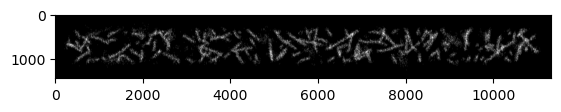

pad_h: 22
pad_w: 6
Padded image shape: torch.Size([1, 1, 1472, 11328])
Patches shape (before reshape): torch.Size([1, 1, 23, 177, 64, 64])
Patches shape: torch.Size([4071, 1, 64, 64])


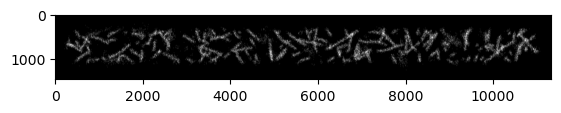

In [16]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')
plt.show()

patches = get_image_patches(image=image_tensor,
                            patch_size=(patch_size,patch_size))
_, channels, height, width = image_tensor.shape
original_image_shape = (1, channels, height, width)
stitched_image = stitch_image_patches(patches=patches,
                                      original_shape=original_image_shape,
                                      patch_size=patch_size)
stitched_image = stitched_image.squeeze().numpy()
plt.imshow(stitched_image, cmap='gray')
plt.show()